# Sentiment Analysis - Labelled Financial News Data

This notebook focuses on conducting sentiment analysis using labeled financial news data. The dataset used in this assignment originates from an automated data scraping framework designed to gather news articles from The Economics Times, a business newspaper from India (although the articles are written in English). Utilizing parallel processing, this framework scrapes articles from the website using a web scraper built with Python's beautifulsoup library. The data extraction process is enhanced with concurrent futures and parallel jobs packages for multiprocessing. This approach facilitated the collection of daily news articles spanning from 2008 to 2022, covering a total of 178 months. The dataset comprises 1,397,114 news articles, each instance containing essential features such as publish date & time, update date , headline, synopsis, sector/genre, and the complete text of the news article. 
(Sources: https://www.kaggle.com/datasets/aravsood7/sentiment-analysis-labelled-financial-news-data; https://arxiv.org/abs/2312.14978)

The assignment involves analysing the sentiment expressed in financial news articles and categorising them as positive, negative, or neutral. The task includes understanding the characteristics of the dataset, exploring its content, preprocessing the text data, selecting appropriate feature representation techniques, training sentiment classifiers, and evaluating their performance. The objective is to develop accurate sentiment analysis models tailored to the financial domain.

##### The data is sourced from The Economic Times (Excluding the copyrighted Prime Articles)


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteotancredi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteotancredi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First let's load the dataset and take a look at the first few rows.

In [46]:
# Load the data from the CSV file with utf-8 encoding
data = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')

# duplicate the data
news = data.copy()

news

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


In [47]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date_published  400 non-null    object
 1   Headline        400 non-null    object
 2   Synopsis        399 non-null    object
 3   Full_text       400 non-null    object
 4   Final Status    400 non-null    object
dtypes: object(5)
memory usage: 15.8+ KB


There is a missing synopsis value in the dataset.

In [48]:
# print the row with the missing value for the 'synopsis' column
news[news['Synopsis'].isnull()]

,Date_published,Headline,Synopsis,Full_text,Final Status
56,2022-04-08,RBI keeps repo rate unchanged; reduces growth ...,NaN,ANIStory outlineThe benchmark repo rate stands...,Negative


Fill the missing value with an empty string.

In [49]:
# fill the missing value with an empty string
news['Synopsis'] = news['Synopsis'].fillna('')

Let's rename the columns to make it more readable.

In [50]:
# rename columns
news = news.rename(
    columns={'Date_published': 'date', 'Headline': 'headline', 'Synopsis': 'synopsis', 'Full_text': 'text',
             'Final Status': 'label'})
news.head()

,date,headline,synopsis,text,label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


Check what kind of labels we have

In [51]:
# print unique labels and their counts
news.label.value_counts()

label
Positive     215
Negative     184
Positive       1
Name: count, dtype: int64

There are 2 labels for positive values: 'Positive' and 'Positive '. 

In [52]:
# remove the spaces from the labels
news['label'] = news['label'].str.strip()

Now, there are only two correct labels: 'Positive' and 'Negative'. Let's analyse the final class distribution.

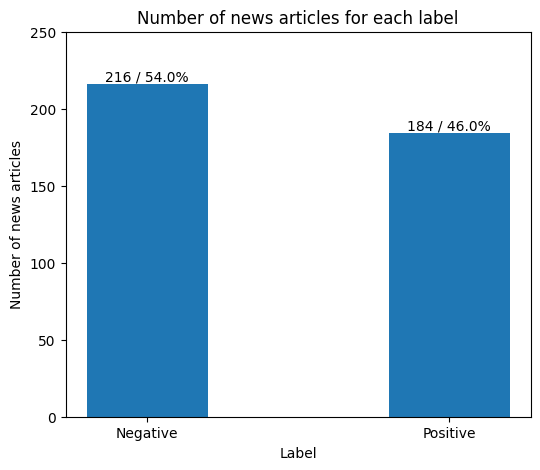

In [53]:
# plot the number of news articles for each label
fig = plt.figure(figsize=(6, 5))
plt.bar(news.label.unique(), news.label.value_counts(), width=0.4)
plt.title('Number of news articles for each label')
plt.xlabel('Label')
plt.ylabel('Number of news articles')
# add the number of news articles on top of each bar
for i, count in enumerate(news.label.value_counts()):
    plt.text(i, count, str(f"{count} / {count/4}%"), ha='center', va='bottom')
# increase the margin at the top of each bar
plt.ylim(0, 250)
plt.show()

As the plot shows, the class distribution is more or less balanced. 

#### Let's clean the text columns:
- Remove punctuation
- Convert the text to lowercase
- Tokenize the text
- Remove stopwords
- Apply PorterStemmer to the tokens

In [54]:
# list of text columns
text_columns = ['headline', 'synopsis', 'text']
# list to store the word tokens columns
word_tokens_columns = []

# stop words
stop_words = set(stopwords.words('english'))

# initialize the stemmer
stemmer = nltk.PorterStemmer()

# duplicate the data
news_cleaned = news.copy()

for col in text_columns:
    # covert each text column to a string
    news_cleaned[col] = news_cleaned[col].astype(str)
    # remove punctuation and non-alpha characters
    news_cleaned[col] = news_cleaned[col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    # create a word token column for each text column
    news_cleaned[col + '_word_tokens'] = news_cleaned[col].apply(word_tokenize)
    # add the column to the list
    word_tokens_columns.append(col + '_word_tokens')
    # remove stopwords from the tokens
    news_cleaned[col + '_word_tokens'] = news_cleaned[col + '_word_tokens'].apply(
        lambda tokens: [token for token in tokens if token not in stop_words])
    # apply PorterStemmer to the tokens
    news_cleaned[col + '_word_tokens'] = news_cleaned[col + '_word_tokens'].apply(
        lambda tokens: [stemmer.stem(token) for token in tokens])

# drop not needed columns
news_cleaned = news_cleaned[word_tokens_columns + ['label']]

news_cleaned

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",Negative
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",Positive
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",Positive
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",Negative
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",Positive
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",Negative
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",Negative
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",Negative
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",Positive


Let's see the most frequent words in the text column

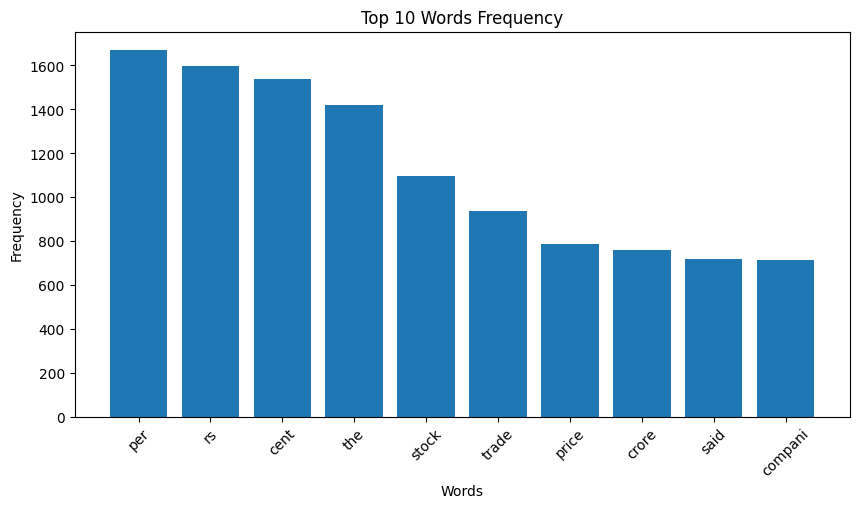

In [55]:
from collections import Counter
from itertools import chain

# Flatten the list of lists
all_words = list(chain.from_iterable(news_cleaned['text_word_tokens']))

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the top N words and their frequencies
top_words = word_freq.most_common(10)

# Extract words and frequencies
top_words, freq = zip(*top_words)

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

Now, let's see the words with the highest TF-IDF scores.

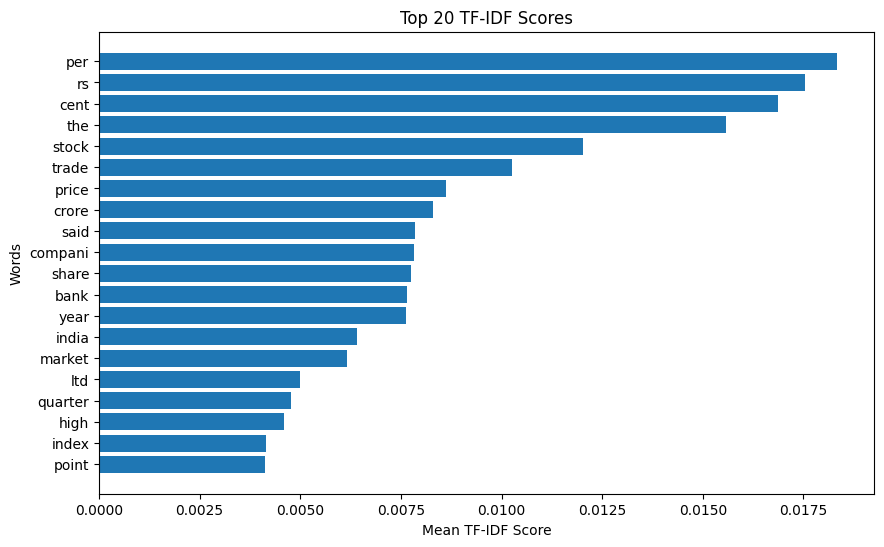

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

doc = news_cleaned['text_word_tokens'].tolist()
new_doc = list(chain.from_iterable(doc))

new_doc = [str(element) for element in new_doc]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(new_doc)
feature_names = tfidf_vectorizer.get_feature_names_out()

mean_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

sorted_indices = np.argsort(mean_tfidf_scores)[::-1]
sorted_words = [feature_names[i] for i in sorted_indices]

top_n = 20
top_words = sorted_words[:top_n]
top_scores = mean_tfidf_scores[sorted_indices][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores)
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Words')
plt.title('Top {} TF-IDF Scores'.format(top_n))
plt.gca().invert_yaxis()
plt.show()

Let's create a word cloud to visualize the most frequent words in the text column.

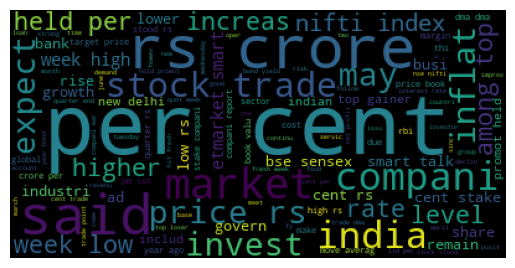

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

corpus = [word for sublist in news_cleaned['text_word_tokens'] for word in sublist]

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Train and evaluate models

After have processing and explore the data, we can now train and evaluate sentiment analysis models using the processed data.

In [58]:
# import the required libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from gensim.models import Word2Vec

# duplicate the cleaned data
df = news_cleaned.copy()

df

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",Negative
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",Positive
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",Positive
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",Negative
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",Positive
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",Negative
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",Negative
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",Negative
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",Positive


We need to convert the label column to binary: 1 for "Positive" and 0 for "Negative".

In [59]:
# transform the label column to binary
df['label'] = df['label'].apply(lambda x: 1 if x == 'Positive' else 0)

df

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",0
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",1
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",1
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",0
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",1
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",0
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",0
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",0
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",1


The following function allows us to train and get the performance of the models.

In [60]:
# Function to train and evaluate models
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return cm, precision, recall, f1


Let's define the models, token columns combinations, and feature representation methods to use in the analysis.


In [61]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(max_iter=1000),
    'Multi-Layer Perceptron': MLPClassifier(max_iter=5000),
    'XGBoost': XGBClassifier()
}

# Define feature representation methods
feature_methods = {
    'Bag of Words': CountVectorizer(),
    'TF-IDF': TfidfVectorizer(),
    'Word2Vec': Word2Vec()
}


In [62]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.exceptions import UndefinedMetricWarning
import warnings

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

results = []

# Outer loop: Iterate through all models
for model_name, model in models.items():
    # print(f'Training and evaluating {model_name}...')
    # Inner loop: Iterate through all token columns combinations
    for i in range(1, len(word_tokens_columns) + 1):
        for j in range(len(word_tokens_columns) - i + 1):
            # print(f"  Token columns: {', '.join(word_tokens_columns[j:j + i])}")
            # Select token columns
            selected_columns = word_tokens_columns[j:j + i]

            # Concatenate tokens within each list
            X = df[selected_columns].apply(lambda x: ' '.join([' '.join(item) for item in x]), axis=1)
            y = df['label']

            # Define cross-validation strategy
            cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            for method_name, method in feature_methods.items():
                if method_name == 'Word2Vec':
                    if model_name in ['Logistic Regression', 'Support Vector Machine', 'Multi-Layer Perceptron', 'XGBoost']:
                        # Train Word2Vec model
                        sentences = [text.split() for text in X]
                        w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

                        # Generate embeddings
                        X_embeddings = []
                        for text in X:
                            embedding = [w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                            if embedding:
                                X_embeddings.append(sum(embedding)/len(embedding))
                            else:
                                # Handle out-of-vocabulary words
                                X_embeddings.append([0] * w2v_model.vector_size)

                        # Train and evaluate the model using cross-validation
                        scores = cross_validate(model, X_embeddings, y, cv=cv_outer,
                                                scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                                                return_train_score=True)

                    else:
                        # Skip Word2Vec for models that don't support embeddings
                        continue
                else:
                    # Vectorize text data
                    X_vec = method.fit_transform(X)

                    # Train and evaluate the model using cross-validation
                    scores = cross_validate(model, X_vec, y, cv=cv_outer,
                                            scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                                            return_train_score=True)

                # Store the results
                for fold in range(len(scores['test_accuracy'])):
                    result = {
                        'Model': model_name,
                        'Token Columns': ', '.join(selected_columns),
                        'Feature Representation': method_name,
                        'Fold': fold + 1,
                        'Fit Time': scores['fit_time'][fold],
                        'Score Time': scores['score_time'][fold],
                        'Train Accuracy': scores['train_accuracy'][fold],
                        'Train Precision': scores['train_precision_macro'][fold],
                        'Train Recall': scores['train_recall_macro'][fold],
                        'Train F1-score': scores['train_f1_macro'][fold],
                        'Test Accuracy': scores['test_accuracy'][fold],
                        'Test Precision': scores['test_precision_macro'][fold],
                        'Test Recall': scores['test_recall_macro'][fold],
                        'Test F1-score': scores['test_f1_macro'][fold]
                    }
                    results.append(result)

# Visualize results
results_df = pd.DataFrame(results)

results_df


,Model,Token Columns,Feature Representation,Fold,Fit Time,Score Time,Train Accuracy,Train Precision,Train Recall,Train F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
0,Naive Bayes,headline_word_tokens,Bag of Words,1,0.000809,0.001976,0.896875,0.903519,0.903091,0.896874,0.7500,0.758730,0.756128,0.749844
1,Naive Bayes,headline_word_tokens,Bag of Words,2,0.000619,0.001783,0.900000,0.900903,0.903425,0.899902,0.7250,0.733333,0.730987,0.724828
2,Naive Bayes,headline_word_tokens,Bag of Words,3,0.000652,0.001757,0.884375,0.890923,0.890508,0.884374,0.6375,0.642677,0.642049,0.637443
3,Naive Bayes,headline_word_tokens,Bag of Words,4,0.000586,0.001747,0.884375,0.895635,0.892041,0.884320,0.7250,0.724203,0.725330,0.724311
4,Naive Bayes,headline_word_tokens,Bag of Words,5,0.000598,0.001746,0.890625,0.897635,0.896370,0.890615,0.5250,0.559561,0.547980,0.509994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Word2Vec,1,0.119591,0.002876,1.000000,1.000000,1.000000,1.000000,0.6250,0.622222,0.620993,0.621212
536,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Word2Vec,2,0.134726,0.003140,1.000000,1.000000,1.000000,1.000000,0.6125,0.609375,0.605594,0.605033
537,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Word2Vec,3,0.191026,0.002627,1.000000,1.000000,1.000000,1.000000,0.5000,0.493230,0.493400,0.492063
538,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Word2Vec,4,0.198983,0.002664,1.000000,1.000000,1.000000,1.000000,0.5375,0.537500,0.537712,0.536849


In [63]:
# save the results to a CSV file with the current date in the name
results_df.to_csv('results/fin_news_sentiment_analysis_results_X_VAl.csv', index=False)

In [64]:
# Load the data from the CSV file with utf-8 encoding
results_csv = pd.read_csv('results/fin_news_sentiment_analysis_results.csv', encoding='utf-8')

# duplicate the data
results = results_csv.copy()

results

,Model,Token Columns,Feature Representation,Confusion Matrix,Precision,Recall,F1-score
0,Naive Bayes,headline_word_tokens,Bag of Words,[[41 14]\n [28 37]],0.725490,0.569231,0.637931
1,Naive Bayes,headline_word_tokens,TF-IDF,[[35 20]\n [26 39]],0.661017,0.600000,0.629032
2,Naive Bayes,synopsis_word_tokens,Bag of Words,[[29 26]\n [35 30]],0.535714,0.461538,0.495868
3,Naive Bayes,synopsis_word_tokens,TF-IDF,[[25 30]\n [25 40]],0.571429,0.615385,0.592593
4,Naive Bayes,text_word_tokens,Bag of Words,[[42 13]\n [35 30]],0.697674,0.461538,0.555556
...,...,...,...,...,...,...,...
103,XGBoost,"synopsis_word_tokens, text_word_tokens",TF-IDF,[[34 21]\n [19 46]],0.686567,0.707692,0.696970
104,XGBoost,"synopsis_word_tokens, text_word_tokens",Word2Vec,[[21 34]\n [21 44]],0.564103,0.676923,0.615385
105,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Bag of Words,[[38 17]\n [10 55]],0.763889,0.846154,0.802920
106,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",TF-IDF,[[32 23]\n [12 53]],0.697368,0.815385,0.751773


In [65]:
sorted_results = results.sort_values(by='F1-score', ascending=False)

sorted_results.head()

,Model,Token Columns,Feature Representation,Confusion Matrix,Precision,Recall,F1-score
105,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Bag of Words,[[38 17]\n [10 55]],0.763889,0.846154,0.802920
91,XGBoost,headline_word_tokens,TF-IDF,[[36 19]\n [11 54]],0.739726,0.830769,0.782609
42,Random Forest,headline_word_tokens,Bag of Words,[[28 27]\n [ 6 59]],0.686047,0.907692,0.781457
56,Support Vector Machine,headline_word_tokens,Word2Vec,[[32 23]\n [ 9 56]],0.708861,0.861538,0.777778
30,Decision Trees,headline_word_tokens,Bag of Words,[[39 16]\n [15 50]],0.757576,0.769231,0.763359


As can be seen in the results above, the model with the highest F1-score on the test set is XGBoost, using all the token columns and using the Bag of Words feature representation. 

Common factors to consider (need to do something with this later):

Ambiguity in Language: Financial news articles often contain ambiguous language or sentiment that is challenging to interpret correctly. This ambiguity can lead to misclassifications, especially if the models struggle to capture the nuanced meaning of certain phrases or words.

Lack of Context: Sentiment analysis models may misclassify articles due to a lack of context. Financial news often references complex market conditions, company performance, and economic indicators that require a deep understanding of the financial domain. If the models lack this context, they may misinterpret the sentiment.

Noise in Data: Financial news datasets may contain noise, such as irrelevant information, noise in labeling, or inaccuracies in data preprocessing. Noise can confuse the models and lead to misclassifications.

Imbalanced Classes: If the dataset is imbalanced, meaning one sentiment class (positive or negative) is significantly more prevalent than the other, the models may be biased toward the majority class and struggle to accurately classify instances from the minority class.

Model Complexity: The complexity of the sentiment analysis models can also impact misclassifications. Overly complex models may overfit the training data and generalize poorly to unseen data, leading to misclassifications.

Feature Representation: The choice of feature representation (e.g., Bag of Words, Word2Vec) can influence model performance. Certain representations may not capture the nuances of financial language effectively, leading to misclassifications.

Tokenization and Preprocessing: Tokenization and preprocessing steps can affect model performance. If the tokenization process does not handle financial jargon or abbreviations properly, it can lead to misclassifications.

Model Hyperparameters: The choice of model hyperparameters (e.g., regularization strength, learning rate) can impact model performance. Suboptimal hyperparameters may lead to misclassifications.

Data Leakage: Data leakage, where information from the test set inadvertently leaks into the training process, can lead to overly optimistic performance estimates and misclassifications on unseen data.

Human Subjectivity: Finally, sentiment analysis inherently involves some degree of subjectivity, as individuals may interpret the sentiment of financial news differently. Misclassifications may occur due to differences in subjective interpretation.

VADER ANALYSIS

In [66]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

news['combined_text'] = news['headline'] + ' ' + news['synopsis'] + ' ' + news['text']

sia = SentimentIntensityAnalyzer()
news['sentiment'] = news['combined_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
news['sentiment_label'] = news['sentiment'].apply(lambda x: 'positive' if x >= 0 else 'negative')


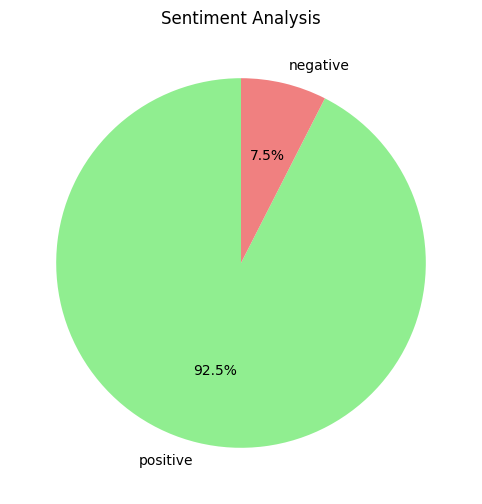

In [67]:
import matplotlib.pyplot as plt

sentiment_counts = news['sentiment_label'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.title('Sentiment Analysis')
plt.show()

LM Analysis

In [68]:
!python3 LM_Analysis/Generic_Parser.py


 ...Loading Master Dictionary 85,000
Master Dictionary loaded from file:
  LoughranMcDonald_MasterDictionary_2023.csv

  master_dictionary has 86,531 words.



Mon Mar 11 10:53:21 2024
PROGRAM NAME: LM_Analysis/Generic_Parser.py

1 : Data/Fin_Cleaned.csv


Runtime: 0:00:00.233005

Normal termination.
Mon Mar 11 10:53:21 2024



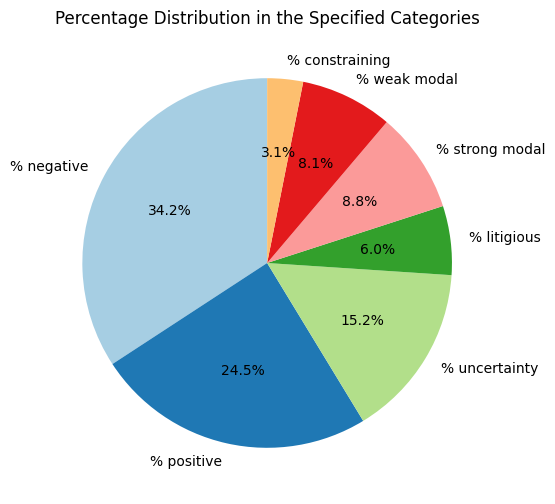

In [69]:
lm_analysis = pd.read_csv('LM_Analysis/Parser.csv')

categories = ['% negative', '% positive', '% uncertainty', '% litigious', '% strong modal', '% weak modal', '% constraining']
data_for_pie = lm_analysis[categories]

plt.figure(figsize=(10, 6))
plt.pie(data_for_pie.mean(), labels=data_for_pie.columns, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Percentage Distribution in the Specified Categories')
plt.show()